In [170]:
import torch
import optuna
import random
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from tqdm import tqdm
from collections import namedtuple, deque
from torch import Tensor

In [171]:
## create an agent 
# agent has a memory, policy network and target network

Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward')
)

class replayMemory(object):
    """
    Memory to give to an agent
    """

    def __init__(self, capacity: int):
        self.memory = deque([], maxlen = capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int):
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        return len(self.memory)

class DQN(nn.Module):
    """
    NNet structure for policy / target networks for agent
    """
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)



class Agent:

    def __init__(
        self,
        policy_lr: float,
        target_lr: float,
        epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,
        memory_size: int
        ):

        self.policy_network = DQN(4, env.action_space.n)
        self.target_network = DQN(4, env.action_space.n)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), policy_lr, amsgrad = True)

        self.discount_factor = discount_factor
        self.target_lr = target_lr

        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.memory = replayMemory(memory_size)

        self.criterion = nn.SmoothL1Loss()


    def get_action(self, state: Tensor) -> int:

        if np.random.random() < self.epsilon:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        else:
            with torch.no_grad():
                action = self.policy_network(state).max(1)[1].view(1,1)#int(torch.argmax(self.policy_network(state)))
            return action

    # def update(self, states, actions, rewards, next_states):




    #     return None

    def experience_replay(self, batch_size):

        samples = self.memory.sample(batch_size)
        batch = Transition(*zip(*samples))
        

        ## perhaps this can all be done by a batch to tensor function?
        non_final_mask = torch.tensor(
            tuple(
                map(
                    lambda s: s is not None,
                    batch.next_state
                    )
                ),
            device = device,
            dtype = torch.bool
        )

        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None]
        )

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        self.optimizer.zero_grad()
        # picks out the relevant values using the actions as indices
        state_action_values = self.policy_network(state_batch).gather(1, action_batch[:,None])

        next_state_values = torch.zeros(batch_size, device = device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]

        expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        loss.backward()

        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()
    
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)







In [172]:
## agent config
config = {
    'policy_lr': 1.0e-4,
    'target_lr': 0.005,
    'epsilon': 0.9,
    'epsilon_decay': 0.01,
    'final_epsilon': 0.05,
    'discount_factor': 0.99,
    'memory_size': 10000
}

BATCH_SIZE = 128
device = 'cpu'


  0%|          | 0/6000 [00:00<?, ?it/s]C:\Users\61417\AppData\Local\Temp/ipykernel_69012/1283342750.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype = torch.float32, device=device)
100%|██████████| 6000/6000 [3:15:18<00:00,  1.95s/it]  


<AxesSubplot:>

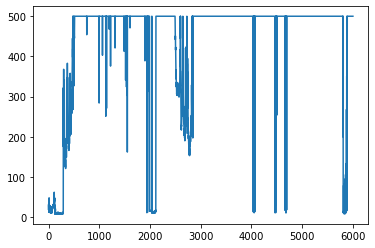

In [173]:

n_episodes = 6000
env = gym.make("CartPole-v1")
agent = Agent(**config)
results = dict()
durations = dict()

for episode in tqdm(range(n_episodes)):
    state, _ = env.reset(seed = 42)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    done = False
    # results[episode] = dict()

    t = 0
    while not done:
        action = agent.get_action(state)

        # results[episode][t] = (obs, action)

        observation, reward, terminated, truncated, _ = env.step(action.item())

        done = terminated or truncated
        # convert to tensors
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        state = torch.tensor(state, dtype = torch.float32, device=device)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        agent.memory.push(state, action, next_state, reward)

        state = next_state

        ## REPLAY MEMORY
        if len(agent.memory) > BATCH_SIZE:
            agent.experience_replay(BATCH_SIZE)

        # soft update of target network
        ## TODO - put into a method attached to the agent
        target_net_state_dict = agent.target_network.state_dict()
        policy_net_state_dict = agent.policy_network.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * agent.target_lr + \
                (1 - agent.target_lr)*target_net_state_dict[key]
        agent.target_network.load_state_dict(target_net_state_dict)
        t+=1
        if done:
            durations[episode] = t
    agent.decay_epsilon()

pd.Series(durations).plot()

In [175]:

n_episodes = 600
env = gym.make("CartPole-v1", render_mode = 'human')
agent = Agent(**config)
results = dict()
durations = dict()

for episode in tqdm(range(n_episodes)):
    state, _ = env.reset(seed = 42)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    done = False
    # results[episode] = dict()

    t = 0
    while not done:
        action = agent.get_action(state)

        # results[episode][t] = (obs, action)

        observation, reward, terminated, truncated, _ = env.step(action.item())

        done = terminated or truncated
        # convert to tensors
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        state = torch.tensor(state, dtype = torch.float32, device=device)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        agent.memory.push(state, action, next_state, reward)

        state = next_state

        ## REPLAY MEMORY
        if len(agent.memory) > BATCH_SIZE:
            agent.experience_replay(BATCH_SIZE)

        # soft update of target network
        ## TODO - put into a method attached to the agent
        target_net_state_dict = agent.target_network.state_dict()
        policy_net_state_dict = agent.policy_network.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * agent.target_lr + \
                (1 - agent.target_lr)*target_net_state_dict[key]
        agent.target_network.load_state_dict(target_net_state_dict)
        t+=1
        if done:
            durations[episode] = t
    agent.decay_epsilon()

pd.Series(durations).plot()

  0%|          | 0/600 [00:00<?, ?it/s]

C:\Users\61417\AppData\Local\Temp/ipykernel_69012/1848727844.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype = torch.float32, device=device)
 57%|█████▋    | 343/600 [15:32<24:31,  5.73s/it]

<AxesSubplot:>

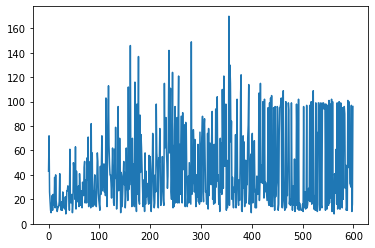

In [159]:
pd.Series(durations).plot()

In [115]:
durations

{99: 20}

In [160]:
samp = agent.memory.sample(len(agent.memory))
transitions = Transition(*zip(*samp))

transitions.state

(tensor([[ 0.0232, -0.0071,  0.0427,  0.0425]]),
 tensor([[ 0.0190, -0.3986,  0.0505,  0.6544]]),
 tensor([[-0.0523, -0.9904,  0.1687,  1.6950]]),
 tensor([[1.0503, 0.6590, 0.1858, 1.4134]]),
 tensor([[0.1611, 0.7155, 0.1467, 0.1498]]),
 tensor([[ 0.0232, -0.3973,  0.0427,  0.6274]]),
 tensor([[2.0128, 1.6078, 0.1517, 0.5279]]),
 tensor([[ 1.2942,  2.0090,  0.0882, -0.3070]]),
 tensor([[ 0.0273, -0.2017,  0.0363,  0.3235]]),
 tensor([[0.2890, 0.8996, 0.1160, 0.0982]]),
 tensor([[ 0.2332,  1.4815,  0.1508, -0.7135]]),
 tensor([[ 0.7050,  1.8352,  0.1267, -0.4876]]),
 tensor([[0.4376, 0.8830, 0.1136, 0.4665]]),
 tensor([[ 0.0667, -0.0369,  0.1425,  0.7063]]),
 tensor([[-0.0010, -0.2064,  0.0854,  0.4281]]),
 tensor([[ 1.3096,  1.8147,  0.0708, -0.0320]]),
 tensor([[ 1.9723,  2.5675,  0.0936, -0.5943]]),
 tensor([[-0.0367,  0.1781,  0.1460, -0.0322]]),
 tensor([[ 0.0274, -0.0061,  0.0359,  0.0197]]),
 tensor([[-0.0187,  0.3684,  0.1374, -0.2218]]),
 tensor([[-0.0166,  0.3576,  0.1671,  0.

In [162]:
torch.cat(transitions.reward).size()

torch.Size([10000])

In [105]:
# dir(env)
torch.gather(k, 1, torch.cat(transitions.action)[:,None])

tensor([[0.3516],
        [0.3534],
        [0.3590],
        [0.3658],
        [0.0930],
        [0.3611],
        [0.3662],
        [0.0898],
        [0.3628],
        [0.3651],
        [0.3641]])

In [104]:
print(k.size(), 0, torch.cat(transitions.action)[:,None].size())

torch.Size([11, 2]) 0 torch.Size([11, 1])


In [96]:
my_tensor = Tensor([[1,2], [3, 4]])
print(
    my_tensor, 
    torch.gather(my_tensor, 1, torch.tensor([[1],[1]])),
    sep = '\n'
)

tensor([[1., 2.],
        [3., 4.]])
tensor([[2.],
        [4.]])
